In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

/Users/michael-tu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [3]:
def load_data(path):
    return pickle.load(open(path, "rb"))

In [4]:
data_sources = ["data/viterbi_dump_k{0}_n100.pk".format(i) for i in range(1,11)]
data_sources

['data/viterbi_dump_k1_n100.pk',
 'data/viterbi_dump_k2_n100.pk',
 'data/viterbi_dump_k3_n100.pk',
 'data/viterbi_dump_k4_n100.pk',
 'data/viterbi_dump_k5_n100.pk',
 'data/viterbi_dump_k6_n100.pk',
 'data/viterbi_dump_k7_n100.pk',
 'data/viterbi_dump_k8_n100.pk',
 'data/viterbi_dump_k9_n100.pk',
 'data/viterbi_dump_k10_n100.pk']

In [5]:
# load data
data = {"d{0}".format(i+1): load_data(data_sources[i]) for i in range(0, 10)}
data.keys()

dict_keys(['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10'])

In [6]:
probs = [0.1, 0.5, 0.81]

err   = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.8]

Ls    = [3, 5]

In [7]:
def show_example(data, i):
    print("Original Message:\n", data[0][i])
    print("Encoded Noisy Message:\n", data[1][i])
    print("Viterbi Decoded Message:\n", data[2][i])

In [8]:
for i in range(3):
    idx = np.random.randint(low=0, high=len(data["d5"]))
    print("idx: ", idx)
    show_example(data["d5"][(0.81, 0.05, 3)], idx)
    print("\n")

idx:  14
Original Message:
 [1. 1. 1. 1. 1.]
Encoded Noisy Message:
 [1 1 1 0 0 1 1 1 0 1 1 0 1 1]
Viterbi Decoded Message:
 [1 1 1 1 1 0 0]


idx:  21
Original Message:
 [1. 1. 1. 1. 1.]
Encoded Noisy Message:
 [1 0 1 0 0 1 0 1 1 1 1 0 1 1]
Viterbi Decoded Message:
 [1 1 1 1 1 0 0]


idx:  12
Original Message:
 [1. 1. 1. 1. 1.]
Encoded Noisy Message:
 [1 1 1 0 0 1 0 1 0 1 1 0 1 1]
Viterbi Decoded Message:
 [1 1 1 1 1 0 0]




In [9]:
def prepare_data(data, length=3, source_channels=None):
    msg, noisy_encode, viterbi_decode = list(), list(), list()
    if source_channels:
        for source in source_channels:
            if source[2] == length:
                for i in range(len(data[source][0])):
                    msg.append(data[source][0][i].astype("float64"))
                    noisy_encode.append(data[source][1][i].astype("float64"))
                    viterbi_decode.append(data[source][2][i][:len(data[source][0][i])].astype("float64"))
    else:
        for i in range(len(data[0])):
            msg.append(data[0][i].astype("float64"))
            noisy_encode.append(data[1][i].astype("float64"))
            viterbi_decode.append(data[2][i][:len(data[0][i])].astype("float64"))

    return  np.array(msg),\
            np.array(noisy_encode),\
            np.array(viterbi_decode).astype("float64")

In [32]:
msg, noisy_encode, viterbi_decode = prepare_data(data["d5"][(0.81, 0.05, 3)])

In [33]:
n = 20
print(msg[n])
print(viterbi_decode[n])

[1. 1. 1. 1. 0.]
[1. 1. 1. 1. 0.]


In [34]:
print(msg.shape)
print(noisy_encode.shape)
print(viterbi_decode.shape)

(100, 5)
(100, 14)
(100, 5)


In [10]:
def accuracy(msg, pred):
    return np.sum(msg == pred) / np.product(pred.shape)

In [36]:
accuracy(msg, viterbi_decode)

0.992

## Baseline viterbi_decoding accuracies:

In [37]:
accuracies = dict()
for k in data:
    accuracies[k] = dict()
    for source_channel in data[k]:
        msg, _, viterbi_decode = prepare_data(data[k][source_channel])
        accuracies[k][source_channel] = accuracy(msg, viterbi_decode)

In [38]:
average_accuracies_per_k = dict()
for k in accuracies:
    average_accuracies_per_k[k] = 0
    for source_channel in accuracies[k]:
        average_accuracies_per_k[k] += accuracies[k][source_channel]
    average_accuracies_per_k[k] /= len(accuracies[k].keys())

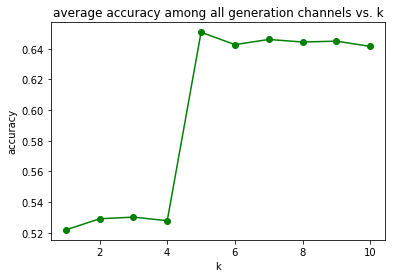

In [39]:
x = [int(x[1:]) for x in list(average_accuracies_per_k.keys())]
y = list(average_accuracies_per_k.values())

plt.title("average accuracy among all generation channels vs. k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.plot(x, y, "g-o")

# Examine Encoding Lengths (Ls)

In [40]:
# Encoding length given different source channels
for source in data["d1"].keys():
    _, x, _ = prepare_data(data["d1"][source])
    print("source {0} has encoding length:\t{1}".format(source, x.shape[1]))

source (0.1, 0.05, 3) has encoding length:	6
source (0.1, 0.05, 5) has encoding length:	10
source (0.1, 0.1, 3) has encoding length:	6
source (0.1, 0.1, 5) has encoding length:	10
source (0.1, 0.15, 3) has encoding length:	6
source (0.1, 0.15, 5) has encoding length:	10
source (0.1, 0.2, 3) has encoding length:	6
source (0.1, 0.2, 5) has encoding length:	10
source (0.1, 0.3, 3) has encoding length:	6
source (0.1, 0.3, 5) has encoding length:	10
source (0.1, 0.5, 3) has encoding length:	6
source (0.1, 0.5, 5) has encoding length:	10
source (0.1, 0.8, 3) has encoding length:	6
source (0.1, 0.8, 5) has encoding length:	10
source (0.5, 0.05, 3) has encoding length:	6
source (0.5, 0.05, 5) has encoding length:	10
source (0.5, 0.1, 3) has encoding length:	6
source (0.5, 0.1, 5) has encoding length:	10
source (0.5, 0.15, 3) has encoding length:	6
source (0.5, 0.15, 5) has encoding length:	10
source (0.5, 0.2, 3) has encoding length:	6
source (0.5, 0.2, 5) has encoding length:	10
source (0.5, 

# Model

In [11]:
def train_test_split(X, y, ratio=0.2):
    indicies = np.arange(len(X), dtype=np.int32)
    np.random.shuffle(indicies)
    
    split_inx = int(len(X) * (1-ratio))
    X_train, X_test = X[indicies[:split_inx]], X[indicies[split_inx:]]
    y_train, y_test = y[indicies[:split_inx]], y[indicies[split_inx:]]
    return X_train, X_test, y_train, y_test

In [12]:
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
data_source_num = 5
encoding_length = 3
BATCH_SIZE = 128
EPOCHS = 50
verbose = 0
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.001
LR = 0.005
optimizer = "adam" # "sgd"

In [24]:
y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                       length=encoding_length, source_channels=source_channels)

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

In [44]:
architecture = [128,100,100]

In [45]:
model = Sequential()
for i, hidden in enumerate(architecture):
    if i == 0:
        model.add(Dense(hidden,  activation=ACTIVATION, input_shape=X_train.shape[1:], 
                        kernel_regularizer=regularizers.l2(l2_reg_strength)))
    else:
        model.add(Dense(hidden,  activation=ACTIVATION, 
                        kernel_regularizer=regularizers.l2(l2_reg_strength)))
        
model.add(Dense(y_train_onehot.shape[1] * 2, activation="sigmoid"))
model.add(Reshape((y_train_onehot.shape[1], 2)))

In [46]:
if optimizer == "adam":
    opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
else:
    opt = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)
                           
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=verbose, 
              validation_split=validation_split, shuffle=True)

In [47]:
print("test accuracy:", model.evaluate(X_test, y_test_onehot)[1])

280/280 [==============================] - 0s 39us/step
test accuracy: 0.7817857078143529


In [13]:
def one_hot(data):
    res = []
    for d in data:
        res.append([0,0])
        res[-1][int(d)] = 1
    return np.array(res)

def one_hot_dataset(dataset):
    return np.array(list(map(lambda x: one_hot(x), dataset)))

def pred_to_decode(pred, threshold="argmax"):
    if type(threshold) == float:
        return np.vstack([1 if x >= threshold else 0 for x in pred])
    elif type(threshold) == str:
        if threshold == "argmax":
            return np.vstack([np.argmax(x, axis=1) for x in pred])
    else:
        return np.vstack(pred)
    
def compare_result(model, threshold=0.5):
    idx = np.random.randint(low=0, high=len(X_test)+1)
    test_x, test_y = X_test[idx:idx+1], y_test_onehot[idx]
    print("Expected: ", [np.argmax(x) for x in test_y])
    pred = model.predict(test_x)
    print("Deocde:   ", pred_to_decode(pred, threshold=threshold)[0])
    
def evaluate(X, y, model):
    y_pred = pred_to_decode(model.predict(X), threshold="argmax")
    return accuracy(y, y_pred)

In [49]:
for i in range(6):
    compare_result(model, threshold="argmax")
    print()

Expected:  [0, 0, 0, 0, 0]
Deocde:    [0 0 0 0 0]

Expected:  [1, 1, 1, 1, 1]
Deocde:    [1 1 1 1 1]

Expected:  [0, 0, 1, 1, 1]
Deocde:    [0 0 1 1 1]

Expected:  [0, 0, 0, 0, 0]
Deocde:    [0 0 0 1 0]

Expected:  [1, 1, 1, 1, 1]
Deocde:    [1 1 1 1 0]

Expected:  [1, 1, 1, 1, 0]
Deocde:    [0 0 1 1 0]



In [50]:
evaluate(X_test, y_test, model)

0.7821428571428571

# Architecture Search

In [14]:
FNN_ARCHITECTURE = [
    [32, 100],
    [64, 100],
    [128, 100],
    [256, 100],
    [32, 32, 100],
    [32, 64, 100],
    [64, 64, 100],
    [64, 128, 100],
    [128, 128, 100],
    [128, 256, 100],
    [256, 256, 100],
    [32,128,128,100],
    [32,128,256,100],
    [32,256,256,100],
    [32,128,256,128,100],
    [32,128,128,128,100],
    [1024,512,100],
    [512,256,100],
    [256,128,100],
    [128,100,100]
]

In [15]:
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
data_source_num = 5
encoding_length = 3
BATCH_SIZE = 64
EPOCHS = 50
verbose = 0
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.001
LR = 0.015
optimizer = "adam" # "sgd"

In [16]:
y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                       length=encoding_length, source_channels=source_channels)

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

In [24]:
def build_train_model(architecture):
    model = Sequential()
    for i, hidden in enumerate(architecture):
        if i == 0:
            model.add(Dense(hidden,  activation=ACTIVATION, input_shape=X_train.shape[1:], 
                            kernel_regularizer=regularizers.l2(l2_reg_strength)))
        else:
            model.add(Dense(hidden,  activation=ACTIVATION, 
                            kernel_regularizer=regularizers.l2(l2_reg_strength)))

    model.add(Dense(y_train_onehot.shape[1] * 2, activation="sigmoid"))
    model.add(Reshape((y_train_onehot.shape[1], 2)))
    if optimizer == "adam":
        opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    else:
        opt = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=verbose, 
                  validation_split=validation_split, shuffle=True)
    
    return model, model.evaluate(X_test, y_test_onehot)[1]

In [55]:
models = {}
losses = {}
for architecture in FNN_ARCHITECTURE:
    name = "model-[{0}]".format(",".join([str(x) for x in architecture]))
    print("  evaluating {0}....".format(name), end="\r")
    m, l = build_train_model(architecture)
    models[name] = m
    losses[name] = l
print("done")

280/280 [==============================] - 0s 38us/step
done


In [56]:
best_model_name = list(losses.keys())[np.argmax(list(losses.values()))]
best_model = models[best_model_name]
print("best model is {0} with loss {1:.5}".format(best_model_name, losses[best_model_name]))

best model is model-[128,100] with loss 0.77929


In [57]:
losses

{'model-[1024,512,100]': 0.7207142863954816,
 'model-[128,100,100]': 0.7489285724503654,
 'model-[128,100]': 0.7792857067925589,
 'model-[128,128,100]': 0.769999989441463,
 'model-[128,256,100]': 0.7564285806247166,
 'model-[256,100]': 0.7535714285714286,
 'model-[256,128,100]': 0.7657142877578735,
 'model-[256,256,100]': 0.7667857119015284,
 'model-[32,100]': 0.7603571449007307,
 'model-[32,128,128,100]': 0.7289285693849836,
 'model-[32,128,128,128,100]': 0.6978571449007307,
 'model-[32,128,256,100]': 0.7110714316368103,
 'model-[32,128,256,128,100]': 0.6982142976352147,
 'model-[32,256,256,100]': 0.706428577218737,
 'model-[32,32,100]': 0.7460714340209961,
 'model-[32,64,100]': 0.7625000034059797,
 'model-[512,256,100]': 0.7567857163293021,
 'model-[64,100]': 0.7485714299338204,
 'model-[64,128,100]': 0.766785717010498,
 'model-[64,64,100]': 0.7403571452413287}

In [58]:
evaluate(X_test, y_test, best_model)

0.7792857142857142

In [59]:
for i in range(6):
    compare_result(best_model, threshold="argmax")
    print()

Expected:  [0, 0, 0, 1, 0]
Deocde:    [0 0 0 1 0]

Expected:  [1, 1, 0, 0, 1]
Deocde:    [0 1 1 0 1]

Expected:  [1, 0, 0, 0, 0]
Deocde:    [0 0 0 0 0]

Expected:  [1, 1, 1, 1, 0]
Deocde:    [0 0 1 1 0]

Expected:  [0, 0, 0, 0, 0]
Deocde:    [0 0 0 0 0]

Expected:  [0, 0, 1, 1, 0]
Deocde:    [0 0 1 1 1]



In [60]:
# best_model.save("models/k5-l3-fnn-{0}.h5".format(best_model_name))

# Accuracy as a function of k

In [76]:
# encoding_length = 3
encoding_length = 3
architecture = [32,100]
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
BATCH_SIZE = 128
EPOCHS = 50
verbose = 0
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.001
LR = 0.001
optimizer = "adam" # "sgd"

In [62]:
losses = dict()
models = dict()
for data_source_num in range(1,11):
    y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

    name = "model-[{0}]-k{1}".format(",".join([str(x) for x in architecture]), data_source_num)
    print("  evaluating {0}....".format(name), end="\r")
    
    model, loss = build_train_model(architecture)
    models[name] = model
    losses[data_source_num] = loss
print("done")

280/280 [==============================] - 0s 42us/step
done


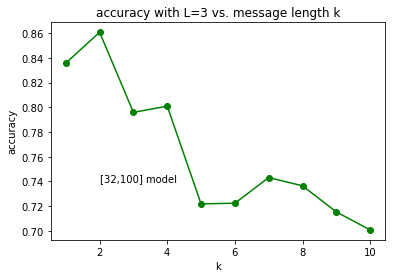

In [63]:
plt_x_axis = np.arange(start=1, stop=11)
plt_y_axis = [losses[k] for k in plt_x_axis]

plt.title("accuracy with L=3 vs. message length k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.text(2, 0.74, "[32,100] model")
plt.plot(plt_x_axis, plt_y_axis, "g-o")

In [64]:
architecture = [32,64,100]
losses = dict()
models = dict()
for data_source_num in range(1,11):
    y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

    name = "model-[{0}]-k{1}".format(",".join([str(x) for x in architecture]), data_source_num)
    print("  evaluating {0}....".format(name), end="\r")
    
    model, loss = build_train_model(architecture)
    models[name] = model
    losses[data_source_num] = loss
print("done")

280/280 [==============================] - 0s 115us/step
done


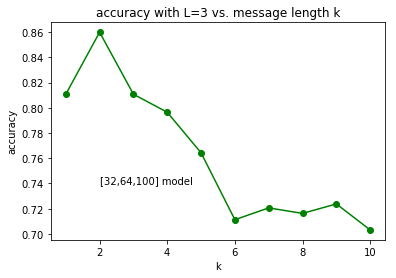

In [65]:
plt_x_axis = np.arange(start=1, stop=11)
plt_y_axis = [losses[k] for k in plt_x_axis]

plt.title("accuracy with L=3 vs. message length k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.text(2, 0.74, "[32,64,100] model")
plt.plot(plt_x_axis, plt_y_axis, "g-o")

280/280 [==============================] - 0s 59us/step
done


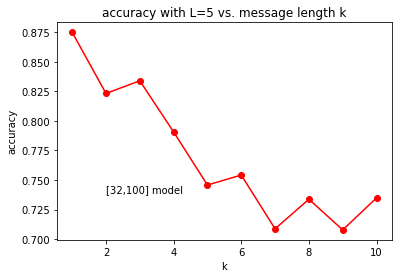

In [66]:
encoding_length = 5
architecture = [32,100]
losses = dict()
models = dict()
for data_source_num in range(1,11):
    y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

    name = "model-[{0}]-k{1}".format(",".join([str(x) for x in architecture]), data_source_num)
    print("  evaluating {0}....".format(name), end="\r")
    
    model, loss = build_train_model(architecture)
    models[name] = model
    losses[data_source_num] = loss
print("done")
plt_x_axis = np.arange(start=1, stop=11)
plt_y_axis = [losses[k] for k in plt_x_axis]

plt.title("accuracy with L=5 vs. message length k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.text(2, 0.74, "[32,100] model")
plt.plot(plt_x_axis, plt_y_axis, "r-o")

280/280 [==============================] - 0s 65us/step
done


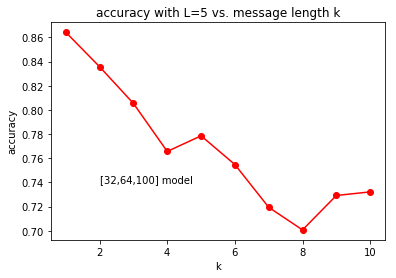

In [77]:
encoding_length = 5
architecture = [32,64,100]
losses = dict()
models = dict()
for data_source_num in range(1,11):
    y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

    name = "model-[{0}]-k{1}".format(",".join([str(x) for x in architecture]), data_source_num)
    print("  evaluating {0}....".format(name), end="\r")
    
    model, loss = build_train_model(architecture)
    models[name] = model
    losses[data_source_num] = loss
print("done")
plt_x_axis = np.arange(start=1, stop=11)
plt_y_axis = [losses[k] for k in plt_x_axis]

plt.title("accuracy with L=5 vs. message length k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.text(2, 0.74, "[32,64,100] model")
plt.plot(plt_x_axis, plt_y_axis, "r-o")

# CNN

In [7]:
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
BATCH_SIZE = 64
EPOCHS = 30
verbose = 2
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.001
LR = 0.01
optimizer = "adam" # "sgd"
PADDING = "same"
keep_prob = 0.5

In [8]:
data_source_num = 5

In [94]:
y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

In [95]:
print(X_train.shape)
print(y_train_onehot.shape)

(1120, 18)
(1120, 5, 2)


In [97]:
X_train_reshaped = X_train.reshape((-1, 2, 9))
X_test = X_test.reshape((-1, 2, 9))
print(X_train_reshaped.shape)

(1120, 2, 9)


In [98]:
model = Sequential()

model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, 
                 activation=ACTIVATION, input_shape=X_train_reshaped.shape[1:]))
model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
# model.add(MaxPooling1D(pool_size=2, padding="same"))
# model.add(AveragePooling1D(pool_size=2, padding="same"))

model.add(Conv1D(filters=16 , kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
# model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
model.add(Flatten())

model.add(Dense(200, activation=ACTIVATION))
model.add(Dropout(keep_prob))

# model.add(Dense(128, activation=ACTIVATION))
# model.add(Dropout(keep_prob))

model.add(Dense(y_train_onehot.shape[1] * 2, activation="sigmoid"))
model.add(Reshape((y_train_onehot.shape[1], 2)))

In [99]:
if optimizer == "adam":
    opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
else:
    opt = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)
    
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=verbose, 
              validation_split=validation_split, shuffle=True)

Train on 896 samples, validate on 224 samples
Epoch 1/30
 - 3s - loss: 0.6302 - acc: 0.6831 - val_loss: 0.5932 - val_acc: 0.7089
Epoch 2/30
 - 0s - loss: 0.5737 - acc: 0.6978 - val_loss: 0.5519 - val_acc: 0.7089
Epoch 3/30
 - 0s - loss: 0.5461 - acc: 0.7011 - val_loss: 0.5459 - val_acc: 0.7188
Epoch 4/30
 - 0s - loss: 0.5251 - acc: 0.7069 - val_loss: 0.5191 - val_acc: 0.7187
Epoch 5/30
 - 0s - loss: 0.5054 - acc: 0.7132 - val_loss: 0.5205 - val_acc: 0.7250
Epoch 6/30
 - 0s - loss: 0.4969 - acc: 0.7152 - val_loss: 0.5099 - val_acc: 0.7205
Epoch 7/30
 - 0s - loss: 0.4868 - acc: 0.7196 - val_loss: 0.5184 - val_acc: 0.7317
Epoch 8/30
 - 0s - loss: 0.4729 - acc: 0.7325 - val_loss: 0.5182 - val_acc: 0.7223
Epoch 9/30
 - 0s - loss: 0.4715 - acc: 0.7324 - val_loss: 0.5014 - val_acc: 0.7397
Epoch 10/30
 - 0s - loss: 0.4606 - acc: 0.7416 - val_loss: 0.4994 - val_acc: 0.7379
Epoch 11/30
 - 0s - loss: 0.4500 - acc: 0.7503 - val_loss: 0.4922 - val_acc: 0.7344
Epoch 12/30
 - 0s - loss: 0.4385 - acc:

In [103]:
for i in range(6):
    compare_result(model, threshold="argmax")
    print()

Expected:  [0, 0, 1, 0, 0]
Deocde:    [0 0 0 0 0]

Expected:  [0, 0, 0, 0, 0]
Deocde:    [1 1 0 0 0]

Expected:  [0, 0, 0, 0, 1]
Deocde:    [0 0 0 0 1]

Expected:  [0, 0, 0, 0, 0]
Deocde:    [0 0 0 0 0]

Expected:  [1, 1, 1, 0, 1]
Deocde:    [1 1 1 0 1]

Expected:  [0, 0, 0, 0, 0]
Deocde:    [0 0 0 0 0]



In [104]:
print("average test accuracy:", evaluate(X_test, y_test, model))

average test accuracy: 0.7635714285714286


In [ ]:
# model.save("models/k5-l3-cnn-v2.h5")

# CNN Architecture

In [105]:
X_train.shape

(1120, 18)

In [115]:
losses = dict()
models = dict()
encoding_length = 5
for data_source_num in range(1,11):
    y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)
    X_train_reshaped = X_train.reshape((-1, 2, int(X_train.shape[1]/2)))
    X_test = X_test.reshape((-1, 2,  int(X_train.shape[1]/2)))
    
    name = "cnn-model-k{0}".format(data_source_num)
    print("  evaluating {0}....".format(name), end="\r")

    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, 
                     activation=ACTIVATION, input_shape=X_train_reshaped.shape[1:]))
    model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
    model.add(Conv1D(filters=16 , kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
    model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
    model.add(Flatten())

    model.add(Dense(200, activation=ACTIVATION))
    model.add(Dropout(keep_prob))

    model.add(Dense(y_train_onehot.shape[1] * 2, activation="sigmoid"))
    model.add(Reshape((y_train_onehot.shape[1], 2)))
    if optimizer == "adam":
        opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    else:
        opt = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_reshaped, y_train_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, 
              verbose=0, validation_split=validation_split, shuffle=True)

    models[name] = model
    losses[data_source_num] = model.evaluate(X_test, y_test_onehot)[1]
print("done")

280/280 [==============================] - 0s 80us/step
done


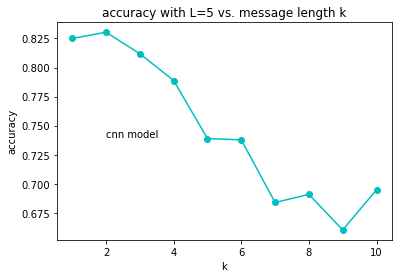

In [117]:
plt_x_axis = np.arange(start=1, stop=11)
plt_y_axis = [losses[k] for k in plt_x_axis]

plt.title("accuracy with L=5 vs. message length k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.text(2, 0.74, "cnn model")
plt.plot(plt_x_axis, plt_y_axis, "c-o")

In [125]:
losses = dict()
models = dict()
encoding_length = 3
for data_source_num in range(1,11):
    y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)
    X_train_reshaped = X_train.reshape((-1, 2, int(X_train.shape[1]/2)))
    X_test = X_test.reshape((-1, 2,  int(X_train.shape[1]/2)))
    
    name = "cnn-model-k{0}".format(data_source_num)
    print("  evaluating {0}....".format(name), end="\r")

    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, 
                     activation=ACTIVATION, input_shape=X_train_reshaped.shape[1:]))
    model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
    model.add(Conv1D(filters=16 , kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
    model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
    model.add(Flatten())

    model.add(Dense(200, activation=ACTIVATION))
    model.add(Dropout(keep_prob))

    model.add(Dense(y_train_onehot.shape[1] * 2, activation="sigmoid"))
    model.add(Reshape((y_train_onehot.shape[1], 2)))
    if optimizer == "adam":
        opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    else:
        opt = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_reshaped, y_train_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, 
              verbose=0, validation_split=validation_split, shuffle=True)

    models[name] = model
    losses[data_source_num] = model.evaluate(X_test, y_test_onehot)[1]
print("done")

280/280 [==============================] - 0s 142us/step
done


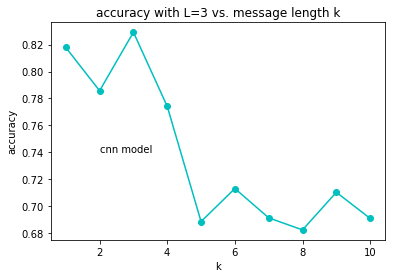

In [126]:
plt_x_axis = np.arange(start=1, stop=11)
plt_y_axis = [losses[k] for k in plt_x_axis]

plt.title("accuracy with L=3 vs. message length k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.text(2, 0.74, "cnn model")
plt.plot(plt_x_axis, plt_y_axis, "c-o")

# CNN on larger length k=100

In [18]:
data_k100 = load_data("data/viterbi_dump_k100_n300.pk")

In [95]:
encoding_length = 5
y, X, _ = prepare_data(data_k100, length=encoding_length, source_channels=source_channels)

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

reshape_dim1 = 16
X_train_reshaped = X_train.reshape((-1, reshape_dim1, int(X_train.shape[1]/reshape_dim1)))
X_test = X_test.reshape((-1, reshape_dim1,  int(X_train.shape[1]/reshape_dim1)))

In [96]:
print(X_train.shape)
print(X_train_reshaped.shape)
print(y_train.shape)
print(y_train_onehot.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test_onehot.shape)

(3360, 208)
(3360, 16, 13)
(3360, 100)
(3360, 100, 2)
(840, 16, 13)
(840, 100)
(840, 100, 2)


In [97]:
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
BATCH_SIZE = 64
EPOCHS = 10
verbose = 2
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.001
LR = 0.01
optimizer = "adam" # "sgd"
PADDING = "same"
keep_prob = 0.5

In [98]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, 
                 activation=ACTIVATION, input_shape=X_train_reshaped.shape[1:]))
model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
model.add(MaxPooling1D(padding="same"))

model.add(Conv1D(filters=16 , kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
model.add(Flatten())

model.add(Dense(128, activation=ACTIVATION))
model.add(Dropout(keep_prob))

model.add(Dense(y_train_onehot.shape[1] * 2, activation="sigmoid"))
model.add(Reshape((y_train_onehot.shape[1], 2)))
if optimizer == "adam":
    opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
else:
    opt = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)

In [99]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, 
          verbose=verbose, validation_split=validation_split, shuffle=True)

Train on 2688 samples, validate on 672 samples
Epoch 1/10
 - 2s - loss: 0.6269 - acc: 0.6912 - val_loss: 0.5831 - val_acc: 0.7042
Epoch 2/10
 - 0s - loss: 0.5755 - acc: 0.7004 - val_loss: 0.5703 - val_acc: 0.7042
Epoch 3/10
 - 0s - loss: 0.5691 - acc: 0.7004 - val_loss: 0.5702 - val_acc: 0.7042
Epoch 4/10
 - 0s - loss: 0.5633 - acc: 0.7004 - val_loss: 0.5692 - val_acc: 0.7042
Epoch 5/10
 - 0s - loss: 0.5590 - acc: 0.7003 - val_loss: 0.5705 - val_acc: 0.7042
Epoch 6/10
 - 0s - loss: 0.5639 - acc: 0.7004 - val_loss: 0.5641 - val_acc: 0.7042
Epoch 7/10
 - 0s - loss: 0.5544 - acc: 0.7003 - val_loss: 0.5626 - val_acc: 0.7042
Epoch 8/10
 - 0s - loss: 0.5490 - acc: 0.7000 - val_loss: 0.5582 - val_acc: 0.7042
Epoch 9/10
 - 0s - loss: 0.5474 - acc: 0.7005 - val_loss: 0.5623 - val_acc: 0.7042
Epoch 10/10
 - 0s - loss: 0.5436 - acc: 0.7003 - val_loss: 0.5633 - val_acc: 0.7040


In [100]:
for i in range(3):
    compare_result(model, threshold="argmax")
    print()

Expected:  [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]
Deocde:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Expected:  [0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]
Deocde:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [127]:
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
BATCH_SIZE = 128
EPOCHS = 20
verbose = 2
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.001
LR = 0.001
optimizer = "adam" # "sgd"
PADDING = "same"
keep_prob = 0.5

In [128]:
encoding_length = 5

In [129]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, strides=1,padding=PADDING, 
                 activation=None, input_shape=X_train_reshaped.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(ACTIVATION))
# model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, strides=1,padding=PADDING, activation=None))
model.add(BatchNormalization())
model.add(Activation(ACTIVATION))
# model.add(Dropout(0.2))

model.add(MaxPooling1D(padding="same"))


model.add(Conv1D(filters=32 , kernel_size=3, strides=1,padding=PADDING, activation=None))
model.add(BatchNormalization())
model.add(Activation(ACTIVATION))
# model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, strides=1,padding=PADDING, activation=None))
model.add(BatchNormalization())
model.add(Activation(ACTIVATION))

model.add(Flatten())

model.add(Dense(300, activation=None))
model.add(BatchNormalization())
model.add(Activation(ACTIVATION))

model.add(Dropout(keep_prob))

model.add(Dense(y_train_onehot.shape[1] * 2, activation="sigmoid"))
model.add(Reshape((y_train_onehot.shape[1], 2)))
if optimizer == "adam":
    opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
else:
    opt = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)

In [130]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, 
          verbose=verbose, validation_split=validation_split, shuffle=True)

Train on 2688 samples, validate on 672 samples
Epoch 1/20
 - 4s - loss: 0.7130 - acc: 0.6032 - val_loss: 0.6035 - val_acc: 0.6862
Epoch 2/20
 - 0s - loss: 0.6057 - acc: 0.6714 - val_loss: 0.6883 - val_acc: 0.7004
Epoch 3/20
 - 1s - loss: 0.5776 - acc: 0.6867 - val_loss: 1.1695 - val_acc: 0.7029
Epoch 4/20
 - 0s - loss: 0.5636 - acc: 0.6916 - val_loss: 1.0347 - val_acc: 0.7032
Epoch 5/20
 - 0s - loss: 0.5570 - acc: 0.6933 - val_loss: 0.7481 - val_acc: 0.7032
Epoch 6/20
 - 0s - loss: 0.5520 - acc: 0.6965 - val_loss: 0.6216 - val_acc: 0.7031
Epoch 7/20
 - 1s - loss: 0.5484 - acc: 0.6978 - val_loss: 0.5584 - val_acc: 0.7011
Epoch 8/20
 - 1s - loss: 0.5444 - acc: 0.6993 - val_loss: 0.5518 - val_acc: 0.7017
Epoch 9/20
 - 1s - loss: 0.5404 - acc: 0.7007 - val_loss: 0.5497 - val_acc: 0.7001
Epoch 10/20
 - 1s - loss: 0.5370 - acc: 0.7018 - val_loss: 0.5482 - val_acc: 0.7011
Epoch 11/20
 - 0s - loss: 0.5333 - acc: 0.7035 - val_loss: 0.5545 - val_acc: 0.6989
Epoch 12/20
 - 1s - loss: 0.5290 - acc

In [131]:
for i in range(3):
    compare_result(model, threshold="argmax")
    print()

Expected:  [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Deocde:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Expected:  [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0]
Deocde:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# FNN on k =100 data

In [57]:
# encoding_length = 3
encoding_length = 5
architecture = [32,128,100]
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
BATCH_SIZE = 128
EPOCHS = 20
verbose = 2
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.01
LR = 0.005
optimizer = "adam" # "sgd"

In [58]:
y, X, _ = prepare_data(data_k100, length=encoding_length, source_channels=source_channels)

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)


In [59]:
model, loss = build_train_model(architecture)

Train on 2688 samples, validate on 672 samples
Epoch 1/20
 - 0s - loss: 1.5781 - acc: 0.6769 - val_loss: 0.7911 - val_acc: 0.7067
Epoch 2/20
 - 0s - loss: 0.6678 - acc: 0.7021 - val_loss: 0.6162 - val_acc: 0.7067
Epoch 3/20
 - 0s - loss: 0.6160 - acc: 0.7021 - val_loss: 0.6076 - val_acc: 0.7067
Epoch 4/20
 - 0s - loss: 0.6108 - acc: 0.7021 - val_loss: 0.6062 - val_acc: 0.7067
Epoch 5/20
 - 0s - loss: 0.6100 - acc: 0.7021 - val_loss: 0.6053 - val_acc: 0.7067
Epoch 6/20
 - 0s - loss: 0.6093 - acc: 0.7021 - val_loss: 0.6059 - val_acc: 0.7067
Epoch 7/20
 - 0s - loss: 0.6098 - acc: 0.7021 - val_loss: 0.6054 - val_acc: 0.7067
Epoch 8/20
 - 0s - loss: 0.6095 - acc: 0.7021 - val_loss: 0.6054 - val_acc: 0.7067
Epoch 9/20
 - 0s - loss: 0.6093 - acc: 0.7021 - val_loss: 0.6054 - val_acc: 0.7067
Epoch 10/20
 - 0s - loss: 0.6093 - acc: 0.7021 - val_loss: 0.6052 - val_acc: 0.7067
Epoch 11/20
 - 0s - loss: 0.6093 - acc: 0.7021 - val_loss: 0.6053 - val_acc: 0.7067
Epoch 12/20
 - 0s - loss: 0.6094 - acc

In [60]:
for i in range(3):
    compare_result(model, threshold="argmax")
    print()

Expected:  [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Deocde:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Expected:  [1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Deocde:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0